![](https://lh3.googleusercontent.com/proxy/jaODgr04WsPPMavdR7zFTE2KMQddkuTtrODvOEfzss4euImyp6UZxHOBGMNWymEzsBYHQLHfS70uJ4bpPisvlXQ29DnBEnZzD16c7i8ajeJ5JOEB1QZ0PCCn_PYNnAs)

In this work I have used the H2O Python library to solve the used cars price prediction problem.
The main idea of H2O is to automatize model training with almost no data preprocessing, hyperparameters tuning and scoring analysis.
All you need is to put all the data in H2O, go through the training process (by default it takes an hour, but you get great results even with faster training) and get the best ensemble for your problem.

Install all needed libraries and packages

In [1]:
!pip install h2o
import os
import pandas as pd
import h2o
from h2o.automl import H2OAutoML

In "hyundi.csv" we see an extra symbols in 'tax' column "(£)" so we need to fix it by renaming to other csv's standard.

In [4]:
full_dataset = pd.DataFrame()

df_hyundi = pd.read_csv('../input/used-car-dataset-ford-and-mercedes/hyundi.csv')
df_hyundi = df_hyundi.rename({'tax(£)': 'tax'}, axis=1)

#add fixed 'hyundi.csv' to the united dataset
full_dataset = pd.concat([full_dataset, df_hyundi])

Go through our directory with dataset and add all files except aforementioned 'hyundi.csv' and 2 'uncleaned' files since they contain duplicate and uncleaned data.

In [6]:
files = [file for file in os.listdir('../input/used-car-dataset-ford-and-mercedes')]
for file in files:
    if file in ['hyundi.csv', 'unclean cclass.csv', 'unclean focus.csv']:
        continue
    df = pd.read_csv('../input/used-car-dataset-ford-and-mercedes/' + file)
    full_dataset = pd.concat([full_dataset, df])

#shuffle data to not have the same manufacturer in train or test splits
full_dataset = full_dataset.sample(frac=1).reset_index(drop=True)

pd.options.display.max_columns = full_dataset.shape[1]

# check whether all data concatenated correctly
print(full_dataset.describe())

                year          price        mileage           tax  \
count  108540.000000  108540.000000  108540.000000  99187.000000   
mean     2017.098028   16890.124046   23025.928469    120.299838   
std         2.130057    9756.266820   21176.423684     63.150926   
min      1970.000000     450.000000       1.000000      0.000000   
25%      2016.000000   10229.500000    7491.750000    125.000000   
50%      2017.000000   14698.000000   17265.000000    145.000000   
75%      2019.000000   20940.000000   32236.000000    145.000000   
max      2060.000000  159999.000000  323000.000000    580.000000   

                mpg     engineSize  
count  99187.000000  108540.000000  
mean      55.166825       1.661644  
std       16.138522       0.557058  
min        0.300000       0.000000  
25%       47.100000       1.200000  
50%       54.300000       1.600000  
75%       62.800000       2.000000  
max      470.800000       6.600000  


In [7]:
# check whether the shuffle was okay
print(full_dataset.head(10))

      model  year  price transmission  mileage fuelType    tax   mpg  \
0        A6  2017  15300       Manual    12386   Diesel  145.0  65.7   
1     C-MAX  2017   9798       Manual    24842   Petrol   30.0  55.4   
2        Q2  2019  21286       Manual      723   Diesel  145.0  49.6   
3   A Class  2019  26250    Automatic      499   Petrol  145.0  53.3   
4      Golf  2016  15499       Manual    31184   Diesel   20.0  67.3   
5     Focus  2018  15250       Manual     3939   Petrol  150.0  57.7   
6   Mokka X  2017  10499       Manual    27969   Petrol  145.0  42.2   
7      Kuga  2017  14795       Manual    25570   Diesel  150.0  60.1   
8      Golf  2017  19798    Semi-Auto     8535   Diesel  150.0  62.8   
9        A1  2015   9698       Manual    61194   Petrol    0.0  67.3   

   engineSize  
0         2.0  
1         1.0  
2         1.6  
3         1.3  
4         2.0  
5         1.0  
6         1.6  
7         2.0  
8         2.0  
9         1.0  


Going through the CSVs we can see that 'cclass.csv' and 'focus.csv' don't have 'tax' and 'mpg' columns.
Let's make sure that the dataset has NaNs because of this and replace them with zeros.

In [8]:
if full_dataset.isnull().values.any():
    full_dataset = full_dataset.fillna(0)
    print('Dataset contained NaNs and now cleaned!')

Dataset contained NaNs and now cleaned!


Run H2O, load united dataset and do a train/test split in 80/20 proportion.
Get our feature/target columns and put them into a 'train' method from 'H2OAutoML' class.
If we set 'stopping_metric' parameter then training doesn't have any time limit so let's set this at 1 hour.
As metric I would choose Mean Average Error and set seed equals to 1 for reproducibility.

In [9]:
h2o.init()

h2o_df = h2o.H2OFrame(full_dataset)

train, test = h2o_df.split_frame(ratios=[.8])

x = train.columns
y = 'price'
x.remove(y)

aml = H2OAutoML(max_runtime_secs=3600, max_models=20, stopping_metric='mae', seed=1)

aml.train(x=x, y=y, training_frame=train)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfjo54mac
  JVM stdout: /tmp/tmpfjo54mac/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpfjo54mac/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_glvia8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_7_AutoML_1_20211016_114204

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2325755.316419998
RMSE: 1525.0427260965505
MAE: 929.9271329840572
RMSLE: 0.07875802887251794
R^2: 0.9768476150261043
Mean Residual Deviance: 2325755.316419998
Null degrees of freedom: 9924
Residual degrees of freedom: 9912
Null deviance: 997021734511.7108
Residual deviance: 23083121515.468483
AIC: 173690.01734347918

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 3339990.6302966145
RMSE: 1827.5641248111144
MAE: 1093.641836111632
RMSLE: 0.09654940946728698
R^2: 0.9650151714097268
Mean Residual Deviance: 3339990.6302966145


Get the table with the best models/ensembles and print info about the very best one.

In [12]:
lb = aml.leaderboard
print(lb.head())

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_7_AutoML_1_20211016_114204,3.33999e+06,1827.56,3.33999e+06,1093.64,0.0965494
StackedEnsemble_AllModels_6_AutoML_1_20211016_114204,3.37279e+06,1836.52,3.37279e+06,1088.41,0.0952003
StackedEnsemble_BestOfFamily_7_AutoML_1_20211016_114204,3.37719e+06,1837.71,3.37719e+06,1094.81,0.0955023
StackedEnsemble_BestOfFamily_4_AutoML_1_20211016_114204,3.38534e+06,1839.93,3.38534e+06,1099.99,0.0956028
StackedEnsemble_AllModels_3_AutoML_1_20211016_114204,3.38749e+06,1840.51,3.38749e+06,1104.86,0.095499
StackedEnsemble_AllModels_4_AutoML_1_20211016_114204,3.38757e+06,1840.54,3.38757e+06,1104.8,0.095475
StackedEnsemble_AllModels_1_AutoML_1_20211016_114204,3.42108e+06,1849.62,3.42108e+06,1110.84,0.09606
StackedEnsemble_AllModels_2_AutoML_1_20211016_114204,3.42152e+06,1849.73,3.42152e+06,1111.94,0.0959804
StackedEnsemble_BestOfFamily_3_AutoML_1_20211016_114204,3.42756e+06,1851.37,3.42756e+06,1110.2,0.0956767
StackedEnsemble_AllModels_5_AutoML_1_20211016_114204,3.42761e+06,1851.38,3.42761e+06,1097.93,0.0955323


Choose the best model as metalearner to provide testing.

In [13]:
best_ensemble = aml.leader
metalearner = h2o.get_model(best_ensemble.metalearner().model_id)

In [14]:
# check all details about the best ensemble like its scores, containing models and their importance
metalearner

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_7_AutoML_1_20211016_114204


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 360440.0 )","nlambda = 100, lambda.max = 1.8361E8, lambda.min = 360440.0, lambd...",20,12,68,levelone_training_StackedEnsemble_AllModels_7_AutoML_1_20211016_11...




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 3325877.329715346
RMSE: 1823.6988045495193
MAE: 1092.9967622462234
RMSLE: 0.09559049365295091
R^2: 0.9651630015854165
Mean Residual Deviance: 3325877.329715346
Null degrees of freedom: 86874
Residual degrees of freedom: 86862
Null deviance: 8293929045794.758
Residual deviance: 288935593019.0207
AIC: 1551191.6474944174

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 3339990.6302966145
RMSE: 1827.5641248111144
MAE: 1093.641836111632
RMSLE: 0.09654940946728698
R^2: 0.9650151714097268
Mean Residual Deviance: 3339990.6302966145
Null degrees of freedom: 86874
Residual degrees of freedom: 86862
Null deviance: 8294168916744.49
Residual deviance: 290161686007.0184
AIC: 1551559.5200137782

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.093388e+03,1.318188e+01,1.077937e+03,1.111456e+03,1.096735e+03,1.083305e+03,1.097508e+03
1,mean_residual_deviance,3.338056e+06,3.267780e+05,3.151233e+06,3.838696e+06,3.434942e+06,3.287410e+06,2.977999e+06
2,mse,3.338056e+06,3.267780e+05,3.151233e+06,3.838696e+06,3.434942e+06,3.287410e+06,2.977999e+06
3,null_deviance,1.658834e+12,2.968202e+10,1.608642e+12,1.660346e+12,1.672194e+12,1.666482e+12,1.686504e+12
4,r2,9.650231e-01,3.487935e-03,9.659260e-01,9.597784e-01,9.640921e-01,9.659905e-01,9.693286e-01
5,residual_deviance,5.800430e+10,5.760222e+09,5.480309e+10,6.678179e+10,6.004278e+10,5.667496e+10,5.171891e+10
6,rmse,1.825320e+03,8.848174e+01,1.775171e+03,1.959259e+03,1.853360e+03,1.813122e+03,1.725688e+03
7,rmsle,9.705370e-02,4.655627e-03,9.564851e-02,9.636745e-02,NaN,1.035945e-01,9.260434e-02



Scoring History: 


,,timestamp,duration,iteration,...,training_rmse,training_deviance,training_mae,training_r2
0,,2021-10-16 13:00:29,0.000 sec,1,...,,,,
1,,2021-10-16 13:00:29,0.005 sec,2,...,,,,
2,,2021-10-16 13:00:29,0.010 sec,3,...,,,,
3,,2021-10-16 13:00:29,0.015 sec,4,...,,,,
4,,2021-10-16 13:00:29,0.020 sec,5,...,7029.667137,49416220.060006,5038.499266,0.482388
5,,2021-10-16 13:00:29,0.061 sec,6,...,,,,
6,,2021-10-16 13:00:29,0.068 sec,7,...,,,,
7,,2021-10-16 13:00:29,0.077 sec,8,...,,,,
8,,2021-10-16 13:00:29,0.085 sec,9,...,,,,
9,,2021-10-16 13:00:29,0.094 sec,10,...,4708.228954,22167419.878826,3324.959793,0.767807



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,XGBoost_grid_1_AutoML_1_20211016_114204_model_2,1997.646973,1.000000,0.208139
1,GBM_4_AutoML_1_20211016_114204,1387.249878,0.694442,0.144540
2,GBM_grid_1_AutoML_1_20211016_114204_model_1,1246.958496,0.624214,0.129923
3,GBM_3_AutoML_1_20211016_114204,892.461792,0.446757,0.092987
4,GBM_2_AutoML_1_20211016_114204,818.454102,0.409709,0.085276
5,XGBoost_1_AutoML_1_20211016_114204,690.210205,0.345512,0.071914
6,GBM_1_AutoML_1_20211016_114204,534.866394,0.267748,0.055729
7,XGBoost_3_AutoML_1_20211016_114204,501.491852,0.251041,0.052251
8,GBM_5_AutoML_1_20211016_114204,449.575409,0.225052,0.046842
9,XGBoost_grid_1_AutoML_1_20211016_114204_model_3,413.705444,0.207096,0.043105


Apply metalearner fot the test set

In [15]:
best_model = aml.get_best_model()
best_model.model_performance(test)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 2708902.0791522143
RMSE: 1645.8742598243082
MAE: 1069.4758144460754
RMSLE: 0.09138941355320518
R^2: 0.9711934455822037
Mean Residual Deviance: 2708902.0791522143
Null degrees of freedom: 21664
Residual degrees of freedom: 21652
Null deviance: 2037327933263.6162
Residual deviance: 58688363544.832726
AIC: 382413.75598876947


Get completed model analysis

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_7_AutoML_1_20211016_114204,3.33999e+06,1827.56,3.33999e+06,1093.64,0.0965494,14423,0.295741,StackedEnsemble
StackedEnsemble_AllModels_6_AutoML_1_20211016_114204,3.37279e+06,1836.52,3.37279e+06,1088.41,0.0952003,32230,0.423929,StackedEnsemble
StackedEnsemble_BestOfFamily_7_AutoML_1_20211016_114204,3.37719e+06,1837.71,3.37719e+06,1094.81,0.0955023,7132,0.065467,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20211016_114204,3.38534e+06,1839.93,3.38534e+06,1099.99,0.0956028,1263,0.0664,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211016_114204,3.38749e+06,1840.51,3.38749e+06,1104.86,0.095499,3040,0.205442,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_1_20211016_114204,3.38757e+06,1840.54,3.38757e+06,1104.8,0.095475,3660,0.201319,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211016_114204,3.42108e+06,1849.62,3.42108e+06,1110.84,0.09606,3017,0.196365,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211016_114204,3.42152e+06,1849.73,3.42152e+06,1111.94,0.0959804,3161,0.241969,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211016_114204,3.42756e+06,1851.37,3.42756e+06,1110.2,0.0956767,1153,0.06178,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_1_20211016_114204,3.42761e+06,1851.38,3.42761e+06,1097.93,0.0955323,43458,0.433857,StackedEnsemble


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

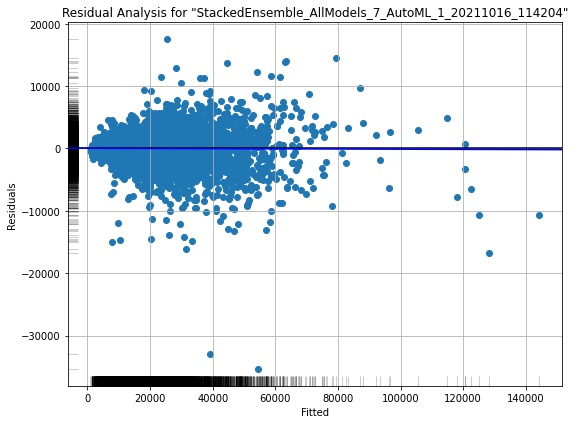

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

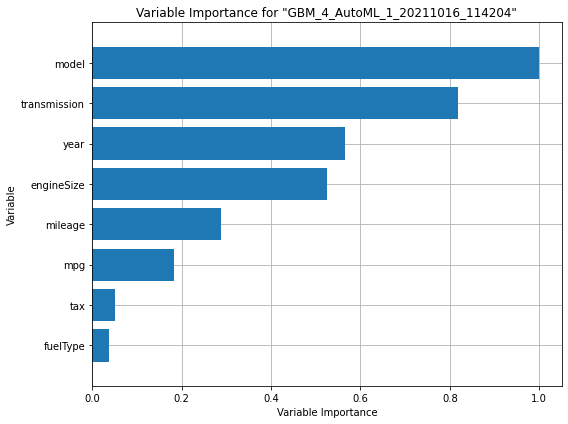

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

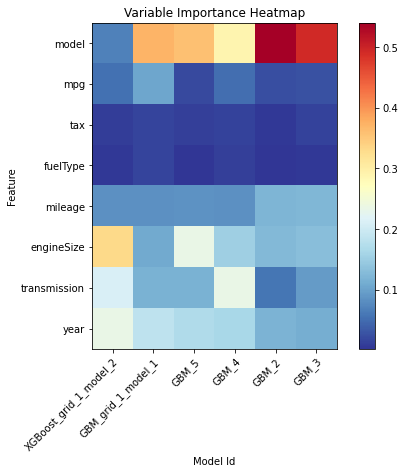

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

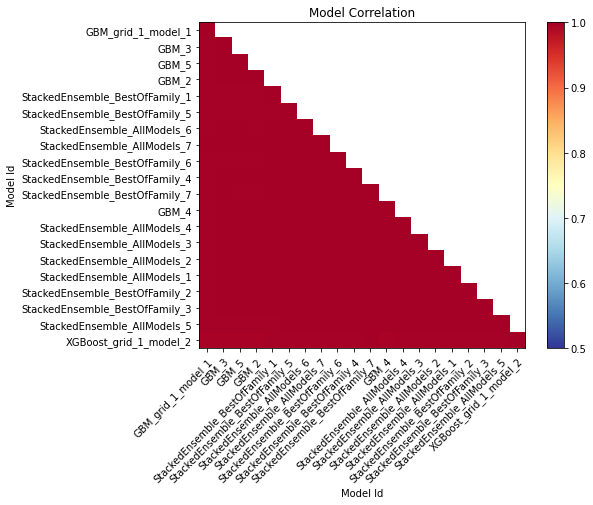

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

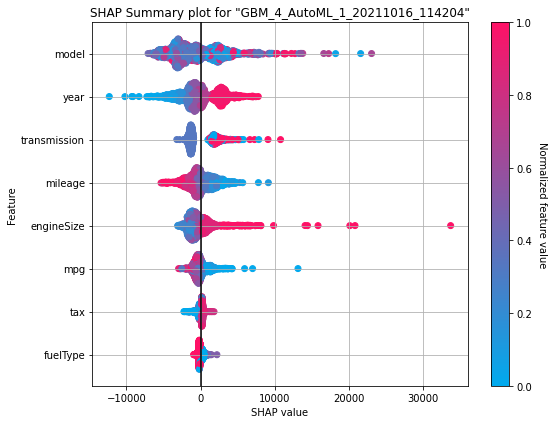

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

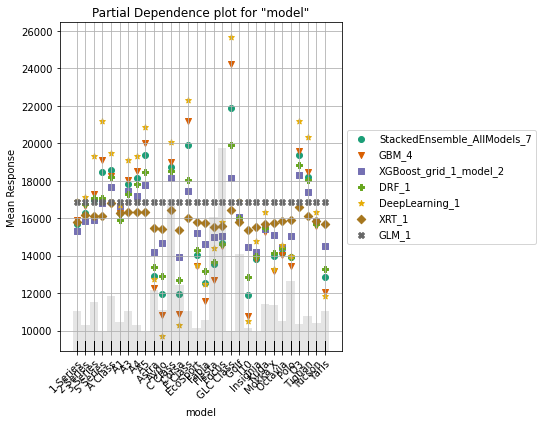

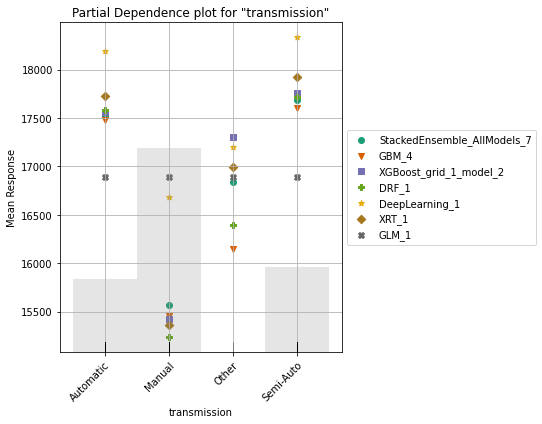

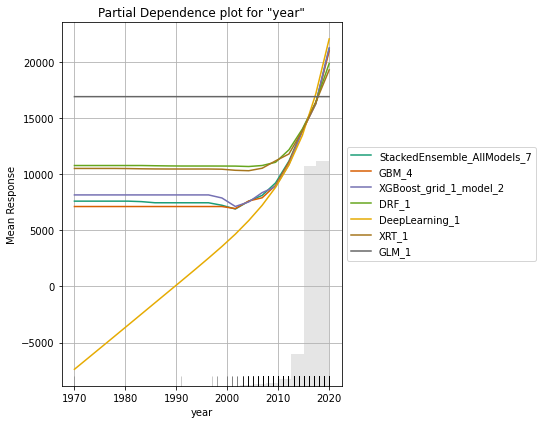

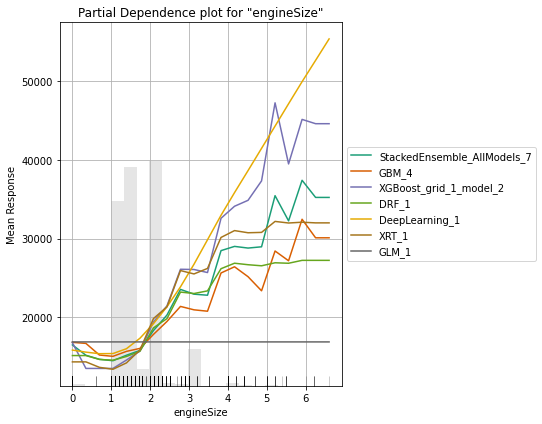

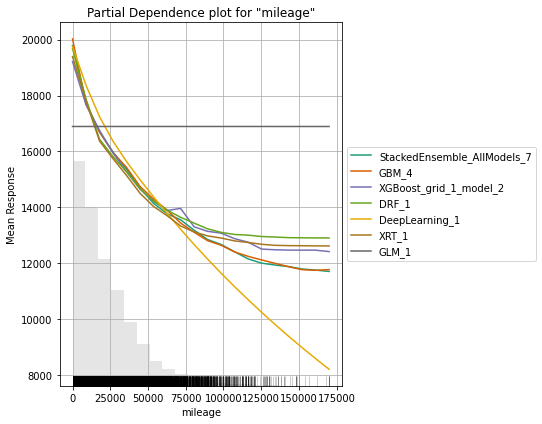

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

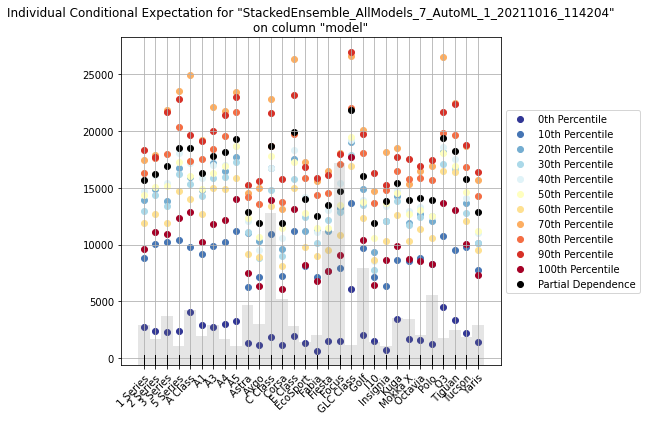

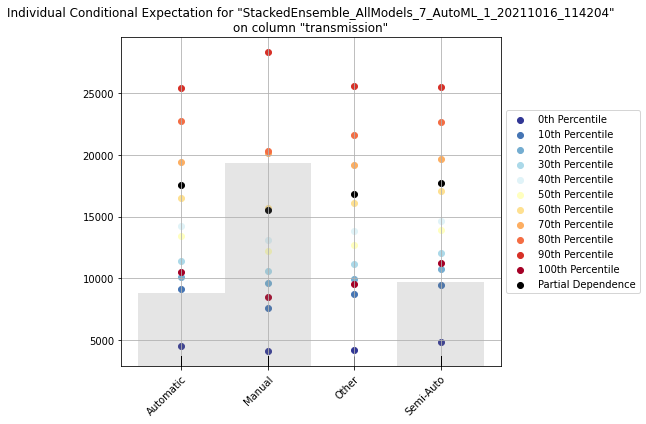

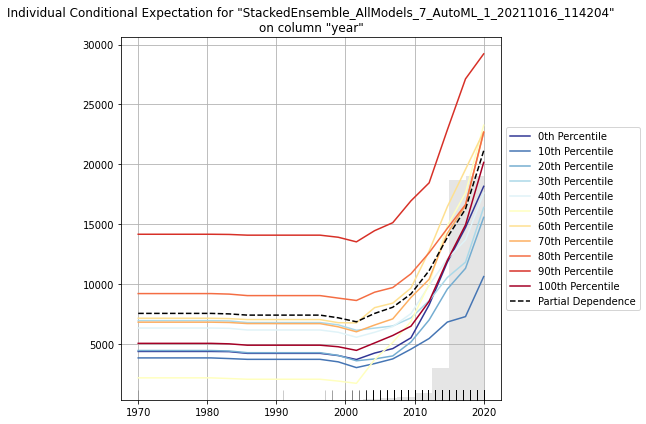

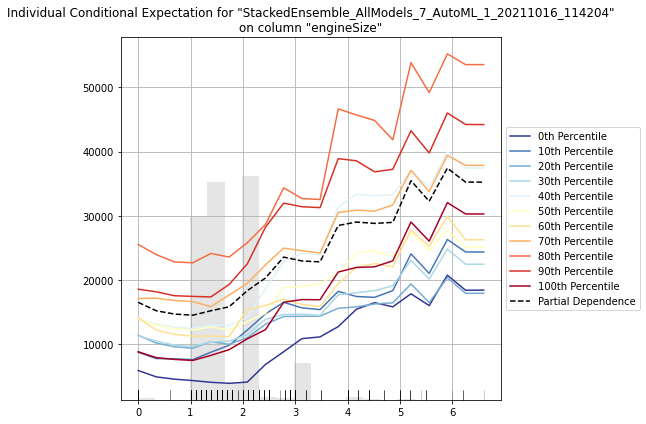

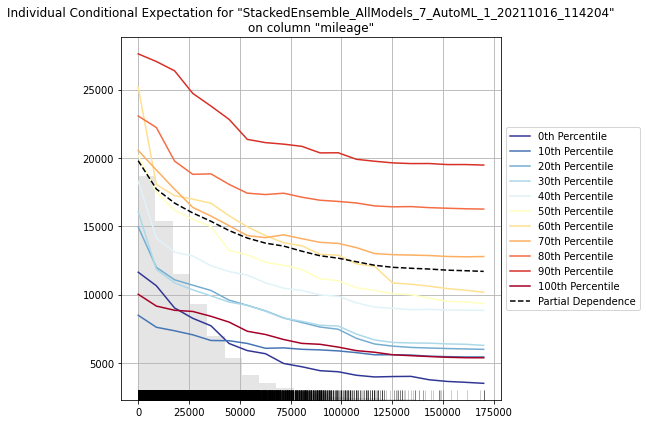

In [17]:
explain_model = aml.explain(frame = test, figsize = (8,6))

Save our model for further use.

In [21]:
model_path = h2o.save_model(model=best_model, path='../output/model', force=True)

**Conclusion**

After H2O AutoML model training I got r^2 score of 0.971. It took some time to tune the model but if we are limited on time we can do model training faster with a little loss of r^2 (down to ~0.95-0.96).
We could have seen that we can successfully use H2O library for regression problems and get relatively good results.

As next steps, we can use H2O AutoML for more complex tasks, like NLP or CV.

This is my first notebook on Kaggle, please upvote if you liked it! Also I will appreciate any feedback on things I could have done better.